# MMORPG Log Generation and Analysis Simulation

This notebook simulates log generation for our fantasy MMORPG based on the defined JSON Lines format.
It then processes these logs to demonstrate how we can extract valuable statistics and insights for monitoring.


## Log Format Definition: JSON Lines

Each log entry will be a single JSON object per line.

**Core Structure (Mandatory Fields):**

```json
{
  "timestamp": "YYYY-MM-DDTHH:MM:SS.sssZ", // ISO 8601 format in UTC. Crucial for chronological ordering and correlation.
  "log_level": "INFO", // ENUM: "INFO", "WARNING", "CRITICAL"
  "event_type": "PVP_KILL", // A standardized string identifying the type of event. See list below.
  "player_uuid": "unique-player-identifier-123", // The primary player associated with this event.
  "player_class": "MAGE", // ENUM: "MAGE", "PALADIN", "WARRIOR", "BARD", "THIEF", "RANGER"
  "location": { // Player's location at the time of the event.
    "x": 123456.78, // double, range -1M to 1M
    "y": -98765.43, // double, range -1M to 1M
    "z": 150.5      // double, range -100 to 2000
  },
  "location_name": "Whispering Caves - Entrance Chamber", // Descriptive name of the area.
  "player_stats": { // Player's relevant stats at the time of the event.
    "ap": 255, // Attack Power (integer)
    "dp": 180, // Defense Power (integer)
    "ap_multiplier": 1.15, // Combined multiplier from buffs/debuffs affecting AP (1.0 = baseline)
    "dp_multiplier": 0.9   // Combined multiplier from buffs/debuffs affecting DP (1.0 = baseline)
  },
  "message": "Player 'ArthasTheJust' (Paladin) defeated Boss 'Gorok the World-Eater'.", // Human-readable summary.

  // --- Optional Data Blocks (Presence depends on event_type) ---
  "target_data": { // Used for interactions involving another entity (player, NPC, Boss)
    "uuid": "unique-player-identifier-456", // Can be player UUID or NPC/Boss ID
    "type": "PLAYER", // ENUM: "PLAYER", "BOSS", "NPC", "MOB"
    "class": "WARRIOR", // Optional: Only if type is PLAYER
    "name": "Gorok the World-Eater" // Optional: Name of the target (Player Name, Boss Name, NPC Name)
  },
  "combat_data": { // Used for combat-related events
    "damage_dealt": 15230,
    "damage_taken": 850,
    "is_killing_blow": true // Boolean, relevant for kill events
  },
  "item_data": { // Used for events involving items (drops, trades, crafts)
    "item_id": "legendary_sword_flamestrider_001", // Unique Item ID or template ID
    "item_name": "Flamestrider, Blade of the Phoenix",
    "rarity": "LEGENDARY", // ENUM: "COMMON", "UNCOMMON", "RARE", "EPIC", "LEGENDARY", "MYTHIC"
    "quantity": 1,
    "unique_instance_id": "unique-serial-if-applicable-xyz" // Optional: For truly unique items
  },
  "trade_data": { // Used specifically for trade events
    "items_offered": [ // List of items offered by the primary player
      { "item_id": "potion_health_major_01", "quantity": 20 },
      { "item_id": "gem_ruby_perfect_01", "quantity": 1 }
    ],
    "items_received": [ // List of items received by the primary player
      { "item_id": "rare_axe_berserker_05", "quantity": 1 }
    ],
    "gold_offered": 5000,
    "gold_received": 0
  },
  "party_data": { // Used for party-related events
    "party_id": "party-unique-id-789",
    "party_size": 4 // Current size of the party after the event
  },
  "guild_data": { // Used for guild-related events
    "guild_id": "guild-unique-id-abc",
    "guild_name": "The Crimson Vanguard"
  },
  "suspicion_data": { // Used for WARNING/CRITICAL logs related to potential cheating
    "reason": "IMPOSSIBLE_MOVEMENT_DETECTED", // Standardized reason code
    "details": "Player moved 5000 units in 0.1s between log points.",
    "previous_location": { "x": 100.0, "y": 200.0, "z": 50.0 } // Optional: Previous known location
  }
}
```

In [1]:
import json
import random
import uuid
import datetime
import time
import os
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## 1. Configuration & Setup

In [2]:
# --- Simulation Parameters ---

NUM_PLAYERS = 250
SIMULATION_DURATION_SECONDS = 60 # Keep short for demo, increase for more data
EVENTS_PER_SECOND = 50 # Average number of loggable events per second across the server
LOG_FILE = "game_logs.jsonl"

In [3]:
# --- Game Data ---

PLAYER_CLASSES = ["MAGE", "PALADIN", "WARRIOR", "BARD", "THIEF", "RANGER"]
LOG_LEVELS = ["INFO", "WARNING", "CRITICAL"] # Corrected: Unique levels matching the weights
LOG_LEVELS_WEIGHTS = [90, 8, 2] # Define weights separately for clarity
ITEM_RARITIES = ["COMMON", "UNCOMMON", "RARE", "EPIC", "LEGENDARY", "MYTHIC"]
ITEM_RARITY_WEIGHTS = [70, 20, 7, 2, 0.9, 0.1] # Weights for random item drop rarity

LOCATIONS = {
    "Aethelburg": {"type": "CITY", "x_range": (-1000, 1000), "y_range": (-1000, 1000), "z_range": (0, 50)},
    "Dragon's Tooth Market": {"type": "CITY", "x_range": (50000, 51000), "y_range": (-2000, -1000), "z_range": (10, 60)},
    "Whispering Caves": {"type": "GRIND_SPOT", "x_range": (15000, 16000), "y_range": (30000, 31000), "z_range": (-50, 20)},
    "Sunken City of Azmar": {"type": "DUNGEON", "x_range": (-200000, -198000), "y_range": (-500000, -498000), "z_range": (-90, 10)},
    "Grakmash's Arena": {"type": "PVP_ZONE", "x_range": (0, 500), "y_range": (80000, 80500), "z_range": (5, 15)},
    "Forgotten Plains": {"type": "GRIND_SPOT", "x_range": (100000, 150000), "y_range": (200000, 250000), "z_range": (0, 100)},
    "The Obsidian Citadel": {"type": "DUNGEON", "x_range": (800000, 801000), "y_range": (-900000,-899000), "z_range": (1500, 1800)}
}
LOCATION_NAMES = list(LOCATIONS.keys())

BOSSES = {
    "Gorok the World-Eater": "The Obsidian Citadel",
    "Seraphina, the Lightbringer": "Sunken City of Azmar",
    "Xylar, the Chronomancer": "Whispering Caves" # Maybe a rare spawn boss
}
BOSS_NAMES = list(BOSSES.keys())

RARE_ITEMS = {
    "RARE": ["Amulet of Keen Sight", "Berserker's Greataxe", "Boots of Silent Steps"],
    "EPIC": ["Shadoweaver Cloak", "Gloves of Arcane Power", "Paladin's Holy Bulwark"],
    "LEGENDARY": ["Flamestrider, Blade of the Phoenix", "Voidreaver, Staff of Entropy"],
    "MYTHIC": ["Shard of the World-Heart"]
}

CHEAT_REASONS = [
    "IMPOSSIBLE_MOVEMENT_DETECTED",
    "ABNORMAL_DAMAGE_OUTPUT",
    "SUSPICIOUS_TRADE_GOLD",
    "SUSPICIOUS_TRADE_ITEM",
    "POTENTIAL_DUPLICATION"
]

In [4]:
# --- Player Simulation Data ---
players = []
player_locations = {} # Store current location {uuid: location_name}
player_coords = {} # Store current coords {uuid: {"x": x, "y": y, "z": z}}
player_stats = {} # Store current stats {uuid: {"ap": ap, ...}}
cheater_uuids = set()

## 2. Helper Functions

In [5]:
def generate_random_coords(location_name):
    """Generates random coordinates within the bounds of a location."""
    loc_data = LOCATIONS[location_name]
    x = round(random.uniform(*loc_data["x_range"]), 2)
    y = round(random.uniform(*loc_data["y_range"]), 2)
    z = round(random.uniform(*loc_data["z_range"]), 2)
    return {"x": x, "y": y, "z": z}

def get_random_rarity():
    """Selects a random item rarity based on weights."""
    return random.choices(ITEM_RARITIES, weights=ITEM_RARITY_WEIGHTS, k=1)[0]

def get_rare_item_name(rarity):
    """Gets a random item name for a given high rarity."""
    if rarity in RARE_ITEMS:
        return random.choice(RARE_ITEMS[rarity])
    return f"{rarity} Generic Item"

def create_base_log(player_uuid, event_type, message, log_level=None):
    """Creates the base structure of a log entry."""
    player_data = next(p for p in players if p["uuid"] == player_uuid)
    location_name = player_locations.get(player_uuid, random.choice(LOCATION_NAMES))
    coords = player_coords.get(player_uuid, generate_random_coords(location_name))
    stats = player_stats.get(player_uuid, {"ap": 100, "dp": 100, "ap_multiplier": 1.0, "dp_multiplier": 1.0}) # Default stats

    log_entry = {
      "timestamp": datetime.datetime.now(datetime.UTC).isoformat(timespec='milliseconds'),
      "log_level": log_level if log_level else random.choices(LOG_LEVELS, weights=LOG_LEVELS_WEIGHTS, k=1)[0],
      "event_type": event_type,
      "player_uuid": player_uuid,
      "player_class": player_data["class"],
      "location": coords,
      "location_name": location_name,
      "player_stats": stats,
      "message": message
    }
    return log_entry

def simulate_player_move(player_uuid):
    """Simulates a player moving, potentially to a new named location."""
    current_loc_name = player_locations.get(player_uuid, random.choice(LOCATION_NAMES))
    # Chance to change named location
    if random.random() < 0.1:
        new_loc_name = random.choice(LOCATION_NAMES)
        while new_loc_name == current_loc_name: # Ensure it's a different location
            new_loc_name = random.choice(LOCATION_NAMES)
        player_locations[player_uuid] = new_loc_name
        player_coords[player_uuid] = generate_random_coords(new_loc_name)
    else:
        # Move within the current named location
        coords = player_coords.get(player_uuid, generate_random_coords(current_loc_name))
        loc_data = LOCATIONS[current_loc_name]
        coords["x"] = round(np.clip(coords["x"] + random.uniform(-50, 50), *loc_data["x_range"]), 2)
        coords["y"] = round(np.clip(coords["y"] + random.uniform(-50, 50), *loc_data["y_range"]), 2)
        coords["z"] = round(np.clip(coords["z"] + random.uniform(-5, 5), *loc_data["z_range"]), 2)
        player_coords[player_uuid] = coords
    # Update stats slightly (simulating buffs wearing off/on)
    stats = player_stats.get(player_uuid, {"ap": 100, "dp": 100, "ap_multiplier": 1.0, "dp_multiplier": 1.0})
    stats["ap_multiplier"] = round(max(0.5, stats["ap_multiplier"] + random.uniform(-0.05, 0.05)), 2)
    stats["dp_multiplier"] = round(max(0.5, stats["dp_multiplier"] + random.uniform(-0.05, 0.05)), 2)
    player_stats[player_uuid] = stats

## 3. Log Generation Simulation

In [6]:
# --- Initialize Players ---
print("Initializing players...")
for i in range(NUM_PLAYERS):
    player_uuid = str(uuid.uuid4())
    player_class = random.choice(PLAYER_CLASSES)
    players.append({"uuid": player_uuid, "class": player_class})
    # Assign starting location and stats
    start_loc = random.choice(LOCATION_NAMES)
    player_locations[player_uuid] = start_loc
    player_coords[player_uuid] = generate_random_coords(start_loc)
    player_stats[player_uuid] = {
        "ap": random.randint(50, 300),
        "dp": random.randint(50, 300),
        "ap_multiplier": 1.0,
        "dp_multiplier": 1.0
    }
    # Designate some players as potential cheaters (for targeted simulation later)
    if random.random() < 0.03: # 3% chance to be a cheater
        cheater_uuids.add(player_uuid)
        print(f"  Designated {player_uuid} ({player_class}) as a potential cheater.")

print(f"\nInitialized {len(players)} players. Designated {len(cheater_uuids)} potential cheaters.")

Initializing players...
  Designated 7c26812e-4f03-4985-bd6b-6763faefa230 (RANGER) as a potential cheater.
  Designated 53dec858-477b-434c-8033-213eaa0b758d (RANGER) as a potential cheater.
  Designated 63df7841-b2f2-40f4-9900-cd4b3400772d (MAGE) as a potential cheater.
  Designated 017143d0-3b4d-404a-90fa-e2bea2c4c6d9 (PALADIN) as a potential cheater.
  Designated fc19cbf6-7c0d-491e-9c82-601c2552da0e (THIEF) as a potential cheater.
  Designated 8f4f62fd-33c7-4428-984f-35d0f7a9bb94 (THIEF) as a potential cheater.
  Designated fadbd929-cae1-4051-904f-7235d42f04a3 (RANGER) as a potential cheater.

Initialized 250 players. Designated 7 potential cheaters.


In [7]:
# --- Simulation Loop ---
print(f"\nStarting simulation for {SIMULATION_DURATION_SECONDS} seconds...")
start_time = time.time()
event_count = 0
last_report_time = start_time

if os.path.exists(LOG_FILE):
    os.remove(LOG_FILE) # Clean up previous run

with open(LOG_FILE, "w") as f:
    while True:
        current_time = time.time()
        elapsed = current_time - start_time
        if elapsed >= SIMULATION_DURATION_SECONDS:
            break

        # Report progress every 5 seconds
        if current_time - last_report_time >= 5:
            print(f"  Elapsed: {int(elapsed)}s, Events Generated: {event_count}")
            last_report_time = current_time

        num_events_this_tick = np.random.poisson(EVENTS_PER_SECOND / 10) # Simulate bursts of activity (adjust rate)
        if num_events_this_tick == 0:
             time.sleep(0.05) # Avoid busy-waiting if no events

        for _ in range(num_events_this_tick):
            event_count += 1
            # Select a random player to perform an action
            player_uuid = random.choice(players)["uuid"]

            # Simulate player movement implicitly - update location/coords
            simulate_player_move(player_uuid)
            player_data = next(p for p in players if p["uuid"] == player_uuid)


            # Determine event type based on player and location
            current_loc_name = player_locations[player_uuid]
            current_loc_type = LOCATIONS[current_loc_name]["type"]

            log_entry = None
            event_prob = random.random()

            # --- Cheater Specific Events ---
            if player_uuid in cheater_uuids and event_prob < 0.15: # 15% chance for cheaters to do something suspicious
                 cheat_type = random.choice(CHEAT_REASONS)
                 if cheat_type == "IMPOSSIBLE_MOVEMENT_DETECTED" and random.random() < 0.4:
                     prev_coords = player_coords[player_uuid].copy()
                     # Simulate a huge jump
                     player_coords[player_uuid]["x"] += random.uniform(50000, 100000) * random.choice([-1,1])
                     player_coords[player_uuid]["y"] += random.uniform(50000, 100000) * random.choice([-1,1])
                     message = f"Suspiciously large movement detected for player {player_uuid}."
                     log_entry = create_base_log(player_uuid, "SUSPICIOUS_MOVEMENT", message, "WARNING")
                     log_entry["suspicion_data"] = {
                         "reason": cheat_type,
                         "details": f"Moved >50k units instantly.",
                         "previous_location": prev_coords
                     }
                 elif cheat_type == "ABNORMAL_DAMAGE_OUTPUT" and random.random() < 0.4:
                     target_player = random.choice([p for p in players if p["uuid"] != player_uuid])
                     damage = random.randint(50000, 200000) # Ridiculously high damage
                     message = f"Player {player_uuid} dealt abnormal damage ({damage}) to {target_player['uuid']}."
                     log_entry = create_base_log(player_uuid, "SUSPICIOUS_COMBAT", message, "CRITICAL")
                     log_entry["combat_data"] = {"damage_dealt": damage, "is_killing_blow": random.choice([True, False])}
                     log_entry["target_data"] = {"uuid": target_player["uuid"], "type": "PLAYER", "class": target_player["class"]}
                     log_entry["suspicion_data"] = {"reason": cheat_type, "details": f"Damage {damage} seems too high for stats."}
                 elif cheat_type == "SUSPICIOUS_TRADE_GOLD" and random.random() < 0.2:
                     target_player = random.choice([p for p in players if p["uuid"] != player_uuid])
                     gold_amount = random.randint(1000000, 50000000) # Huge gold amount
                     message = f"Suspiciously large gold trade ({gold_amount}g) from {player_uuid} to {target_player['uuid']}."
                     log_entry = create_base_log(player_uuid, "SUSPICIOUS_TRADE", message, "WARNING")
                     log_entry["trade_data"] = {"items_offered": [], "items_received": [], "gold_offered": gold_amount, "gold_received": 0}
                     log_entry["target_data"] = {"uuid": target_player["uuid"], "type": "PLAYER", "class": target_player["class"]}
                     log_entry["suspicion_data"] = {"reason": cheat_type, "details": f"Large gold transfer with no items exchanged."}

            # --- Normal Events (if not a cheat event) ---
            elif current_loc_type == "PVP_ZONE" and event_prob < 0.1: # Higher chance of PvP in PvP zones
                target_player = random.choice([p for p in players if p["uuid"] != player_uuid])
                message = f"Player {player_uuid} ({player_data['class']}) engaged Player {target_player['uuid']} ({target_player['class']}) in PvP."
                log_entry = create_base_log(player_uuid, "PVP_ENCOUNTER", message) # Could be PVP_KILL or just encounter
                log_entry["target_data"] = {"uuid": target_player["uuid"], "type": "PLAYER", "class": target_player["class"]}
                if random.random() < 0.4: # 40% chance the encounter results in a kill
                     log_entry["event_type"] = "PVP_KILL"
                     log_entry["message"] = f"Player {player_uuid} ({player_data['class']}) defeated Player {target_player['uuid']} ({target_player['class']}) in PvP."
                     log_entry["combat_data"] = {"damage_dealt": random.randint(500, 5000), "is_killing_blow": True}

            elif current_loc_type == "DUNGEON" and event_prob < 0.05: # Chance to kill a boss in a dungeon
                 possible_bosses = [b for b, l in BOSSES.items() if l == current_loc_name]
                 if possible_bosses:
                     boss_name = random.choice(possible_bosses)
                     message = f"Player {player_uuid} ({player_data['class']}) [{log_entry['player_stats']['ap'] if log_entry else 'N/A'} AP] contributed to defeating Boss '{boss_name}'."
                     log_entry = create_base_log(player_uuid, "BOSS_KILL_CONTRIBUTOR", message)
                     # Simplified: Assume kill if contributing
                     if random.random() < 0.2: # Chance this player got the killing blow / log represents the kill event
                         log_entry["event_type"] = "BOSS_KILL"
                         log_entry["message"] = f"Player {player_uuid} ({player_data['class']}) defeated Boss '{boss_name}'."
                         log_entry["combat_data"] = {"is_killing_blow": True, "damage_dealt": random.randint(1000, 10000)}
                         log_entry["target_data"] = {"uuid": f"boss_{boss_name.lower().replace(' ', '_')}", "type": "BOSS", "name": boss_name}
                         # Chance for rare drop on boss kill
                         if random.random() < 0.3:
                             rarity = random.choices(ITEM_RARITIES, weights=[0,0,10, 40, 40, 10],k=1)[0] # Higher chance for good loot from bosses
                             item_name = get_rare_item_name(rarity)
                             item_id = f"{rarity.lower()}_{item_name.lower().replace(' ', '_')}_{random.randint(1000,9999)}"
                             drop_log = create_base_log(player_uuid, f"ITEM_DROP_{rarity}", f"Player {player_uuid} obtained [{item_name}] ({rarity}) from {boss_name}.")
                             drop_log["item_data"] = {"item_id": item_id, "item_name": item_name, "rarity": rarity, "quantity": 1}
                             drop_log["target_data"] = {"uuid": f"boss_{boss_name.lower().replace(' ', '_')}", "type": "BOSS", "name": boss_name}
                             f.write(json.dumps(drop_log) + "\n")
                             event_count += 1 # Count the extra log

            elif current_loc_type == "CITY" and event_prob < 0.08: # Higher chance of trading in cities
                target_player = random.choice([p for p in players if p["uuid"] != player_uuid])
                item_rarity = get_random_rarity()
                item_name = get_rare_item_name(item_rarity)
                item_id = f"{item_rarity.lower()}_{item_name.lower().replace(' ', '_')}_{random.randint(1000,9999)}"
                gold_amount = random.randint(10, 10000) * (ITEM_RARITIES.index(item_rarity) + 1) # Price scales roughly with rarity

                message = f"Player {player_uuid} completed trade with {target_player['uuid']}."
                log_entry = create_base_log(player_uuid, "TRADE_COMPLETE", message)
                # Simulate offering item or gold
                if random.random() < 0.5:
                    log_entry["trade_data"] = {
                        "items_offered": [{"item_id": item_id, "quantity": 1, "item_name": item_name, "rarity": item_rarity}],
                        "items_received": [],
                        "gold_offered": 0,
                        "gold_received": gold_amount
                    }
                else:
                    log_entry["trade_data"] = {
                        "items_offered": [],
                        "items_received": [{"item_id": item_id, "quantity": 1, "item_name": item_name, "rarity": item_rarity}],
                        "gold_offered": gold_amount,
                        "gold_received": 0
                    }
                log_entry["target_data"] = {"uuid": target_player["uuid"], "type": "PLAYER", "class": target_player["class"]}


            elif current_loc_type == "GRIND_SPOT" and event_prob < 0.03: # Chance for rare drop while grinding
                rarity = get_random_rarity()
                if ITEM_RARITIES.index(rarity) >= ITEM_RARITIES.index("RARE"): # Log only RARE+ drops from grinding
                    item_name = get_rare_item_name(rarity)
                    item_id = f"{rarity.lower()}_{item_name.lower().replace(' ', '_')}_{random.randint(1000,9999)}"
                    message = f"Player {player_uuid} obtained [{item_name}] ({rarity}) while adventuring in {current_loc_name}."
                    log_entry = create_base_log(player_uuid, f"ITEM_DROP_{rarity}", message)
                    log_entry["item_data"] = {"item_id": item_id, "item_name": item_name, "rarity": rarity, "quantity": 1}
                    # Could add optional target_data for the mob type if needed

            # --- Generic Login/Logout (less frequent) ---
            elif event_prob < 0.001:
                 log_entry = create_base_log(player_uuid, "PLAYER_LOGIN", f"Player {player_uuid} logged in.")
            elif event_prob < 0.002:
                 log_entry = create_base_log(player_uuid, "PLAYER_LOGOUT", f"Player {player_uuid} logged out.")

            # Write the generated log entry (if one was created)
            if log_entry:
                f.write(json.dumps(log_entry) + "\n")

        # Small sleep to prevent pure CPU burn and allow time progression
        #time.sleep(0.01)


print(f"\nSimulation finished. Generated {event_count} log events in {LOG_FILE}")


Starting simulation for 60 seconds...
  Elapsed: 5s, Events Generated: 40926
  Elapsed: 10s, Events Generated: 79447
  Elapsed: 15s, Events Generated: 117625
  Elapsed: 20s, Events Generated: 161585
  Elapsed: 25s, Events Generated: 201249
  Elapsed: 30s, Events Generated: 244968
  Elapsed: 35s, Events Generated: 284903
  Elapsed: 40s, Events Generated: 324753
  Elapsed: 45s, Events Generated: 364049
  Elapsed: 50s, Events Generated: 402367
  Elapsed: 55s, Events Generated: 443235

Simulation finished. Generated 480379 log events in game_logs.jsonl


## 4. Log Processing and Analysis

In [8]:
# --- Load Logs ---
print(f"Loading logs from {LOG_FILE}...")
try:
    # Load the JSON Lines file. Pandas might automatically try to infer datetime,
    # but we will explicitly convert it afterwards for consistency.
    logs_df = pd.read_json(LOG_FILE, lines=True)
    print(f"Successfully loaded {len(logs_df)} log entries.")

    # --- Basic Data Cleaning & Preparation ---

    # --- Timestamp Parsing ---
    # Ensure the timestamp column exists before proceeding
    if 'timestamp' in logs_df.columns:
        print("Attempting to parse timestamps...")
        original_timestamps_dtype = logs_df['timestamp'].dtype
        print(f"  Original timestamp dtype: {original_timestamps_dtype}")

        # Convert timestamp using pandas' built-in ISO8601 parser.
        # utc=True correctly handles the '+00:00' offset and makes the column timezone-aware (UTC).
        # errors='coerce' turns unparseable entries into NaT (Not a Time).
        logs_df['timestamp'] = pd.to_datetime(logs_df['timestamp'], utc=True, errors='coerce')

        # Check how many timestamps failed to parse
        failed_parses = logs_df['timestamp'].isnull().sum()
        if failed_parses > 0:
            print(f"Warning: {failed_parses} out of {len(logs_df)} timestamp(s) failed to parse and were set to NaT.")
            # You might want to investigate the original strings if failures occur:
            # print("Example original timestamps that failed parsing:")
            # print(logs_df[logs_df['timestamp'].isnull()]['timestamp'].iloc[:5]) # Show original strings if needed (might need to reload with dtype=str)
        else:
            print("All timestamps parsed successfully.")
        print(f"  New timestamp dtype: {logs_df['timestamp'].dtype}")
    else:
        print("Error: 'timestamp' column not found in the loaded data.")
        # Create an empty NaT column if missing, to prevent later errors
        logs_df['timestamp'] = pd.NaT
    # --- End Timestamp Parsing ---


    # --- Extract Nested Data Fields Safely ---
    print("\nExtracting nested data fields...")

    # Extract coordinates for plotting safely
    if 'location' in logs_df.columns:
        logs_df['x'] = logs_df['location'].apply(lambda loc: loc.get('x') if isinstance(loc, dict) else None)
        logs_df['y'] = logs_df['location'].apply(lambda loc: loc.get('y') if isinstance(loc, dict) else None)
        print("  Extracted 'x' and 'y' coordinates.")
    else:
        logs_df['x'] = None
        logs_df['y'] = None
        print("  Warning: 'location' column not found or has unexpected format. Set 'x' and 'y' to None.")

    # Extract target UUID for analysis safely
    if 'target_data' in logs_df.columns:
        logs_df['target_uuid'] = logs_df['target_data'].apply(lambda data: data.get('uuid') if isinstance(data, dict) else None)
        print("  Extracted 'target_uuid'.")
    else:
        logs_df['target_uuid'] = None
        print("  Warning: 'target_data' column not found. Set 'target_uuid' to None.")

    # Extract item rarity for analysis safely
    if 'item_data' in logs_df.columns:
        logs_df['item_rarity'] = logs_df['item_data'].apply(lambda data: data.get('rarity') if isinstance(data, dict) else None)
        print("  Extracted 'item_rarity'.")
    else:
        logs_df['item_rarity'] = None
        print("  Warning: 'item_data' column not found. Set 'item_rarity' to None.")

    # Extract suspicion reason safely
    if 'suspicion_data' in logs_df.columns:
        logs_df['suspicion_reason'] = logs_df['suspicion_data'].apply(lambda data: data.get('reason') if isinstance(data, dict) else None)
        print("  Extracted 'suspicion_reason'.")
    else:
        logs_df['suspicion_reason'] = None
        print("  Warning: 'suspicion_data' column not found. Set 'suspicion_reason' to None.")

    print("Nested data extraction complete.")
    # --- End Nested Data Extraction ---


except FileNotFoundError:
    print(f"ERROR: Log file '{LOG_FILE}' not found. Did the simulation run correctly?")
    logs_df = pd.DataFrame() # Create empty df to avoid errors below
except Exception as e: # Catch broader exceptions during loading/parsing
    print(f"ERROR during log processing: {e}")
    # Consider printing the full traceback for debugging complex errors:
    # import traceback
    # traceback.print_exc()
    logs_df = pd.DataFrame() # Initialize empty df on error

# --- Final Check and Info ---
if not logs_df.empty:
    print("\n--- Post-Processing DataFrame Info ---")
    print(logs_df.info())
    print("\n--- Sample Log Entries (Processed) ---")
    print(logs_df.head())

else:
    print("\nDataFrame is empty after loading/processing attempts.")

Loading logs from game_logs.jsonl...
Successfully loaded 25276 log entries.
Attempting to parse timestamps...
  Original timestamp dtype: datetime64[ns, UTC]
All timestamps parsed successfully.
  New timestamp dtype: datetime64[ns, UTC]

Extracting nested data fields...
  Extracted 'x' and 'y' coordinates.
  Extracted 'target_uuid'.
  Extracted 'item_rarity'.
  Extracted 'suspicion_reason'.
Nested data extraction complete.

--- Post-Processing DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25276 entries, 0 to 25275
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   timestamp         25276 non-null  datetime64[ns, UTC]
 1   log_level         25276 non-null  object             
 2   event_type        25276 non-null  object             
 3   player_uuid       25276 non-null  object             
 4   player_class      25276 non-null  object             
 5   locati

## 5. Visualizations


Generating Plot 1: Player Concentration Heatmap...


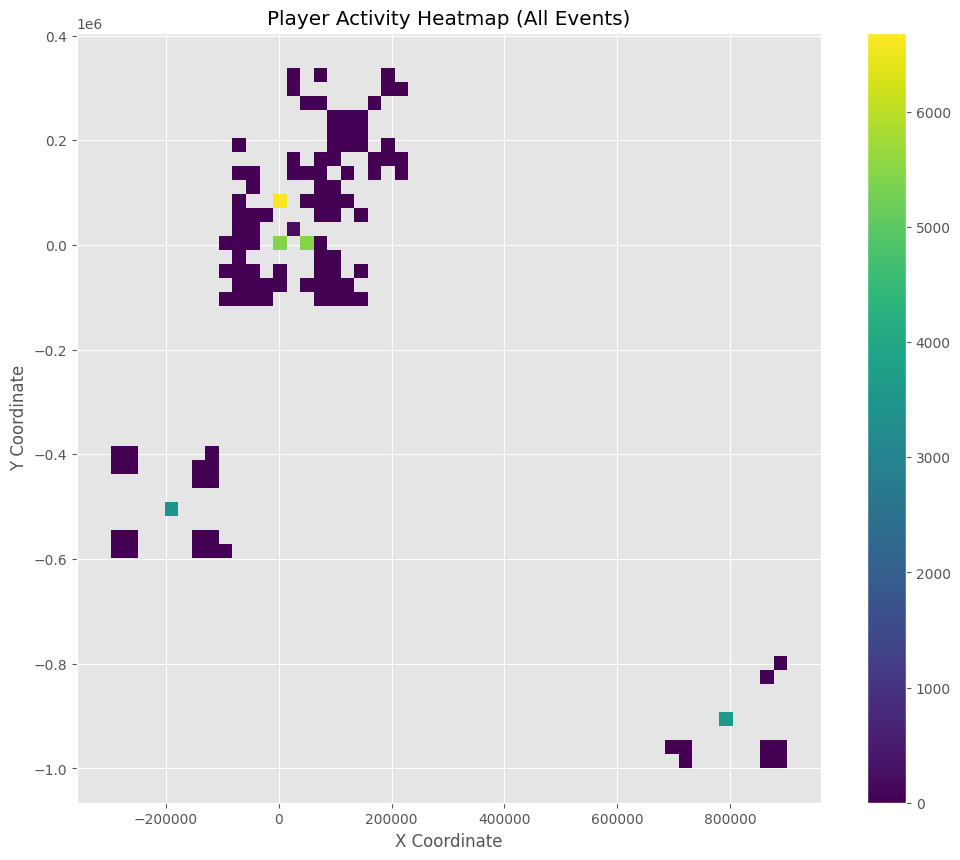


Generating Plot 2: Most Popular Locations...


<ipython-input-9-d2991597e4bd>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=location_counts.index, y=location_counts.values, palette="magma")


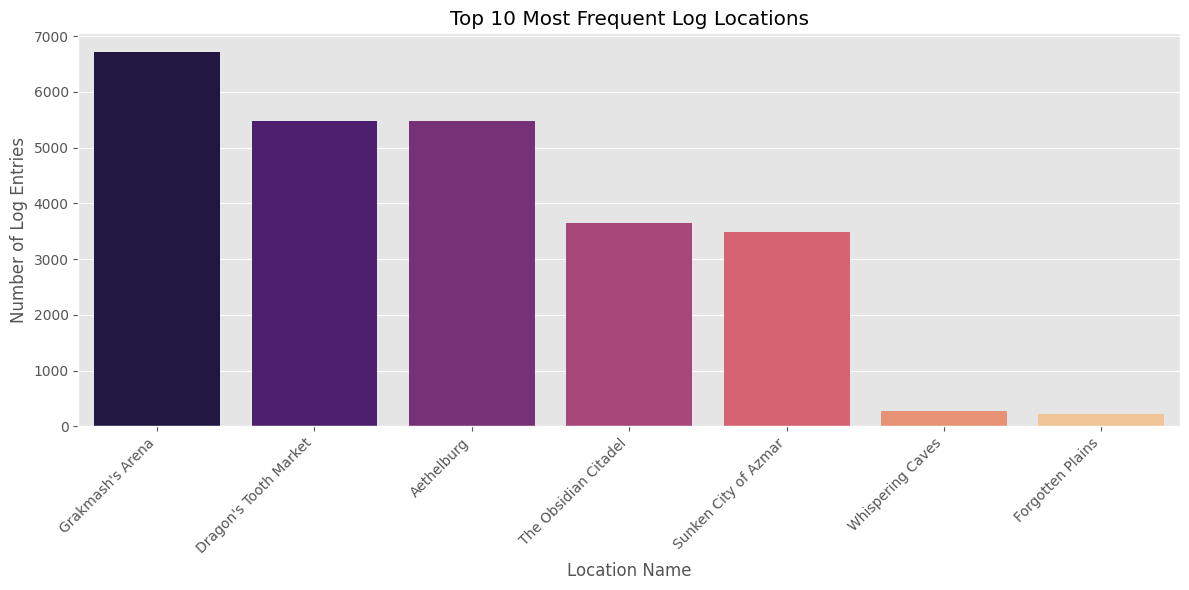


Generating Plot 3: Event Type Distribution...


<ipython-input-9-d2991597e4bd>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=event_counts.index, x=event_counts.values, palette="viridis", orient='h')


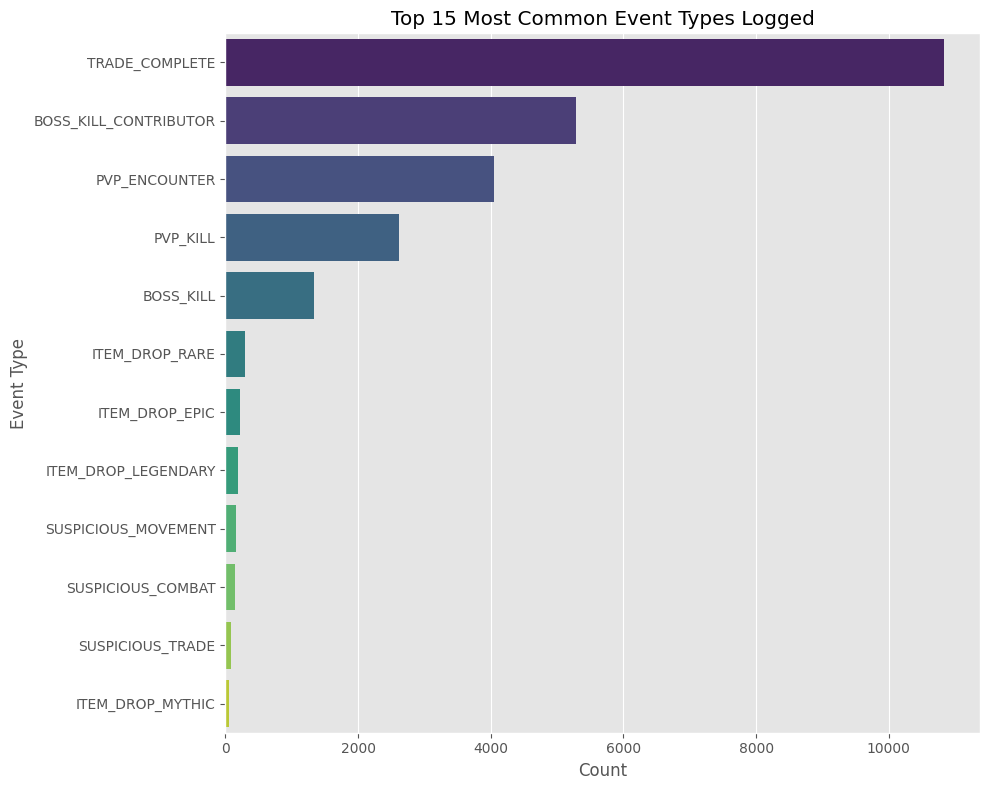


Generating Plot 4: PvP Leaders...


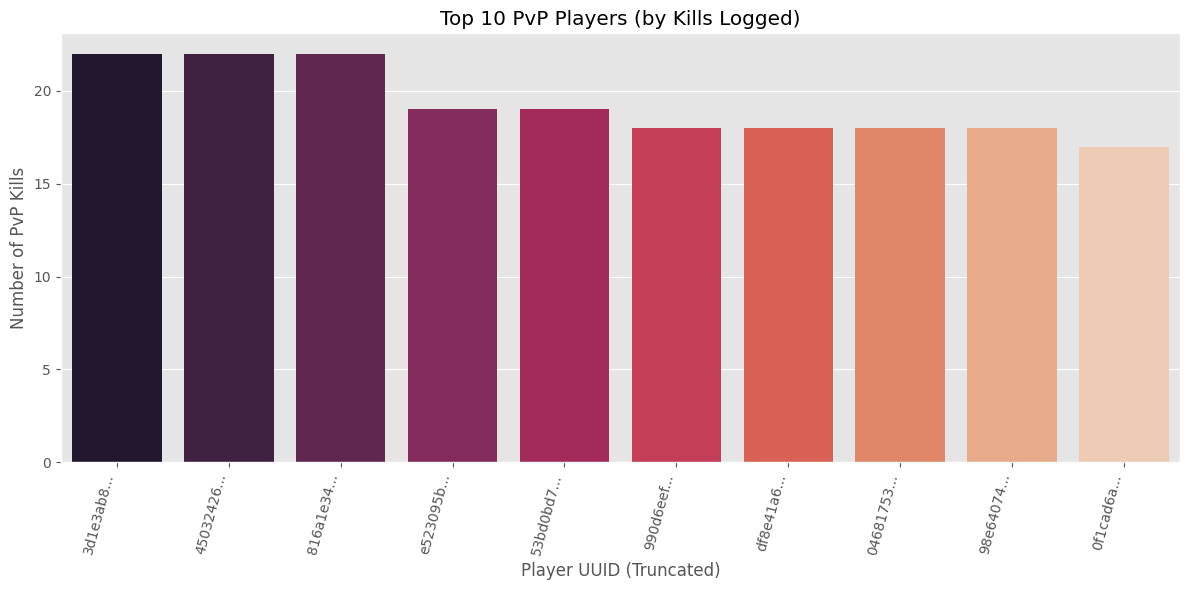


Generating Plot 5: Boss Kill Leaders...


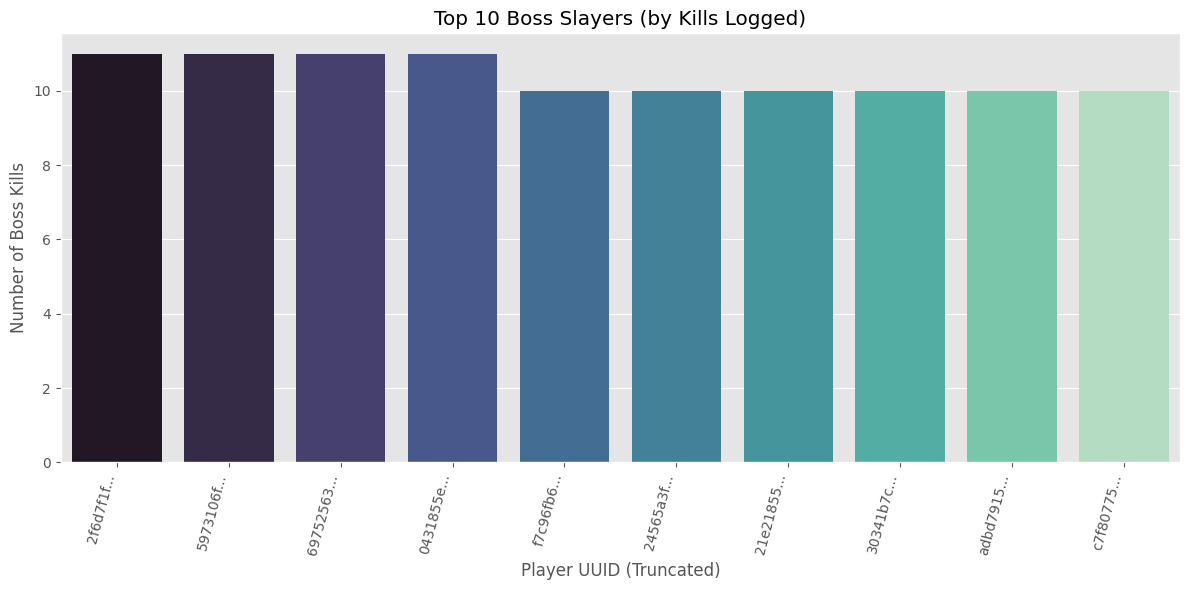


Generating Plot 6: Luckiest Players...


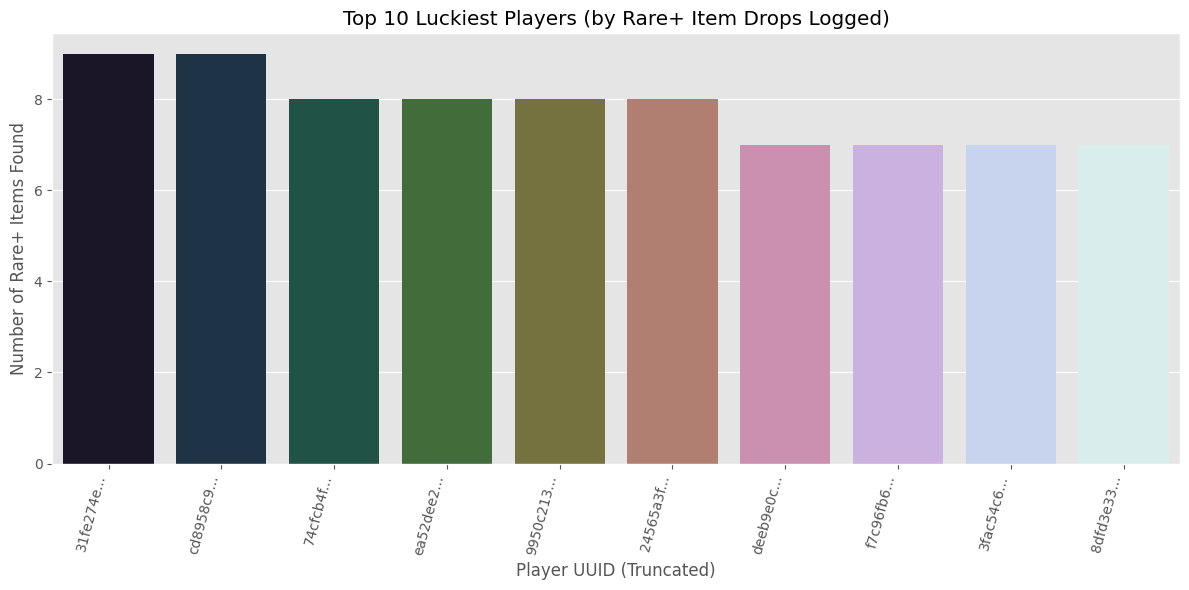


Generating Plot 7: Suspicious Activity Breakdown...


<ipython-input-9-d2991597e4bd>:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=suspicion_counts.index, y=suspicion_counts.values, palette="Reds_r")


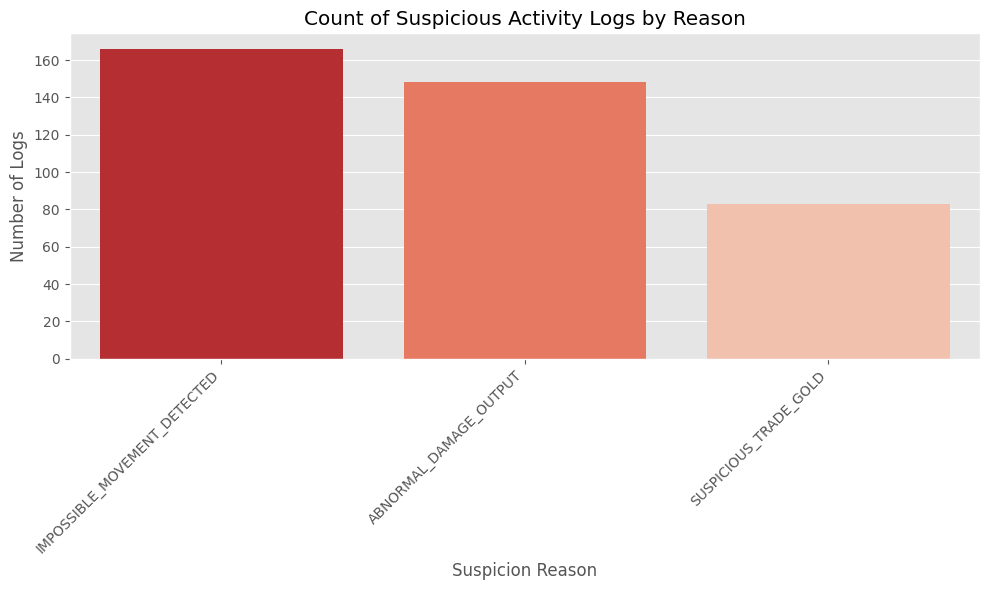


Players with most suspicious logs:
player_uuid
fc19cbf6-7c0d-491e-9c82-601c2552da0e    70
63df7841-b2f2-40f4-9900-cd4b3400772d    66
017143d0-3b4d-404a-90fa-e2bea2c4c6d9    61
8f4f62fd-33c7-4428-984f-35d0f7a9bb94    57
7c26812e-4f03-4985-bd6b-6763faefa230    54
fadbd929-cae1-4051-904f-7235d42f04a3    50
53dec858-477b-434c-8033-213eaa0b758d    39
26f7465a-05a5-4a29-a317-987d41ed8f85    21
d22c37cd-fc32-4783-b5d8-4681caa8ceaf    20
deeb9e0c-c0df-427f-933b-207ab99f345f    18
Name: count, dtype: int64

Sample logs for most flagged player (fc19cbf6...):
                            timestamp log_level           event_type  \
435  2025-04-26 11:00:55.326000+00:00   WARNING     SUSPICIOUS_TRADE   
616  2025-04-26 11:00:55.821000+00:00   WARNING  SUSPICIOUS_MOVEMENT   
1411 2025-04-26 11:00:57.597000+00:00  CRITICAL    SUSPICIOUS_COMBAT   
2488 2025-04-26 11:00:59.882000+00:00  CRITICAL    SUSPICIOUS_COMBAT   
2687 2025-04-26 11:01:00.373000+00:00  CRITICAL    SUSPICIOUS_COMBAT   

           

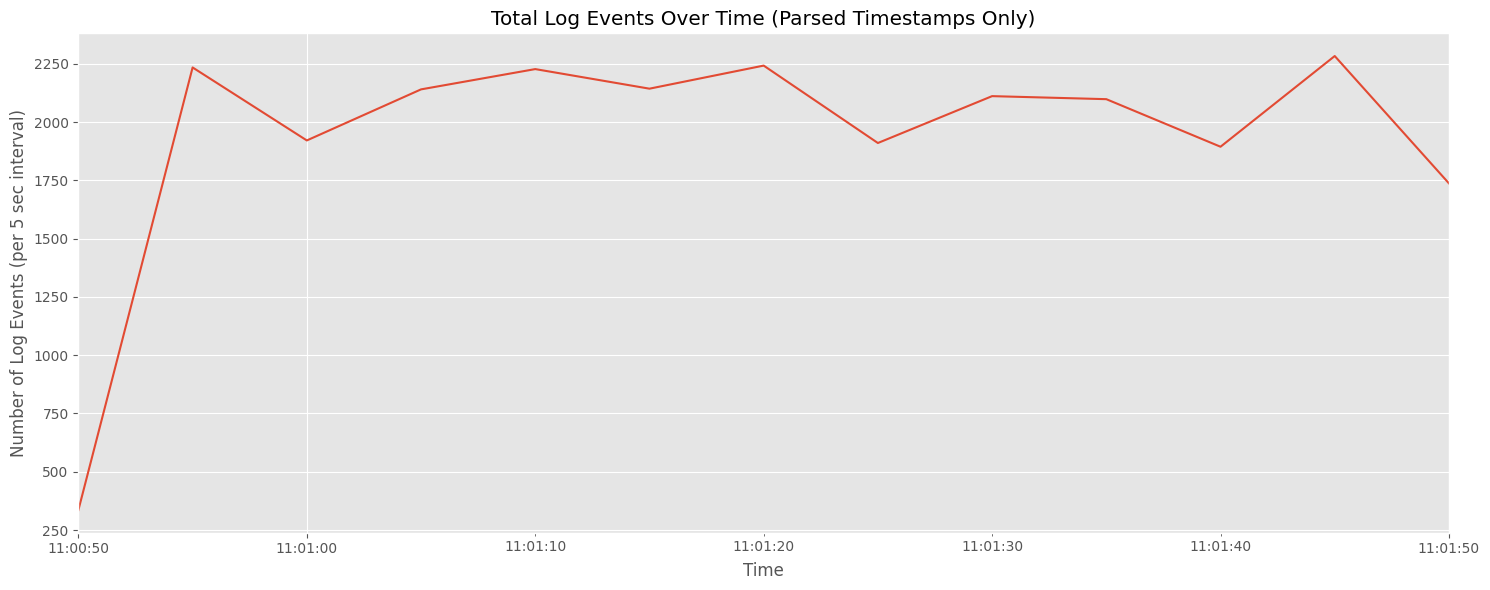



Analysis Complete.


In [9]:
if not logs_df.empty:
    plt.style.use('ggplot') # Set a plotting style

    # --- Visualization 1: Player Concentration Heatmap ---
    print("\nGenerating Plot 1: Player Concentration Heatmap...")
    plt.figure(figsize=(12, 10))
    # Use histplot for density or kdeplot for smoothed density
    sns.histplot(data=logs_df, x="x", y="y", bins=50, cmap="viridis", cbar=True)
    # sns.kdeplot(data=logs_df, x="x", y="y", cmap="viridis", fill=True, thresh=0.05, levels=100) # Alternative: Smoothed KDE
    plt.title('Player Activity Heatmap (All Events)')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    # Optional: Limit axes if needed, but ranges are large
    # plt.xlim(-300000, 900000)
    # plt.ylim(-1000000, 300000)
    plt.grid(True)
    plt.show()

    # --- Visualization 2: Most Popular Locations ---
    print("\nGenerating Plot 2: Most Popular Locations...")
    plt.figure(figsize=(12, 6))
    location_counts = logs_df['location_name'].value_counts().nlargest(10) # Top 10
    sns.barplot(x=location_counts.index, y=location_counts.values, palette="magma")
    plt.title('Top 10 Most Frequent Log Locations')
    plt.xlabel('Location Name')
    plt.ylabel('Number of Log Entries')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # --- Visualization 3: Event Types Distribution ---
    print("\nGenerating Plot 3: Event Type Distribution...")
    plt.figure(figsize=(10, 8))
    event_counts = logs_df['event_type'].value_counts().nlargest(15) # Top 15 event types
    sns.barplot(y=event_counts.index, x=event_counts.values, palette="viridis", orient='h')
    plt.title('Top 15 Most Common Event Types Logged')
    plt.xlabel('Count')
    plt.ylabel('Event Type')
    plt.tight_layout()
    plt.show()

    # --- Visualization 4: PvP Leaders ---
    print("\nGenerating Plot 4: PvP Leaders...")
    pvp_kills = logs_df[logs_df['event_type'] == 'PVP_KILL']
    if not pvp_kills.empty:
        pvp_leaders = pvp_kills['player_uuid'].value_counts().nlargest(10)
        plt.figure(figsize=(12, 6))
        # Fix FutureWarning: Assign x to hue and disable legend
        sns.barplot(x=pvp_leaders.index, y=pvp_leaders.values, hue=pvp_leaders.index, palette="rocket", legend=False)
        plt.title('Top 10 PvP Players (by Kills Logged)')
        plt.xlabel('Player UUID (Truncated)')
        plt.ylabel('Number of PvP Kills')
        # Corrected xticks: Provide both tick positions and labels
        plt.xticks(ticks=np.arange(len(pvp_leaders)), # Positions 0, 1, 2...
                labels=[label[:8] + '...' for label in pvp_leaders.index], # Truncated labels
                rotation=75, ha='right') # Added ha='right' for better alignment with rotation
        plt.tight_layout()
        plt.show()
    else:
        print("  No PvP Kills logged in this simulation run.")

    # --- Visualization 5: Boss Kill Leaders ---
    print("\nGenerating Plot 5: Boss Kill Leaders...")
    boss_kills = logs_df[logs_df['event_type'] == 'BOSS_KILL']
    if not boss_kills.empty:
        boss_killers = boss_kills['player_uuid'].value_counts().nlargest(10)
        plt.figure(figsize=(12, 6))
        # Fix FutureWarning: Assign x to hue and disable legend
        sns.barplot(x=boss_killers.index, y=boss_killers.values, hue=boss_killers.index, palette="mako", legend=False)
        plt.title('Top 10 Boss Slayers (by Kills Logged)')
        plt.xlabel('Player UUID (Truncated)')
        plt.ylabel('Number of Boss Kills')
        # Corrected xticks: Provide both tick positions and labels
        plt.xticks(ticks=np.arange(len(boss_killers)), # Positions 0, 1, 2...
                labels=[label[:8] + '...' for label in boss_killers.index], # Truncated labels
                rotation=75, ha='right') # Added ha='right'
        plt.tight_layout()
        plt.show()
    else:
        print("  No Boss Kills logged in this simulation run.")

    # --- Visualization 6: Luckiest Players (Rare+ Item Drops) ---
    print("\nGenerating Plot 6: Luckiest Players...")
    rare_drops = logs_df[logs_df['item_rarity'].isin(['RARE', 'EPIC', 'LEGENDARY', 'MYTHIC'])]
    if not rare_drops.empty:
        lucky_players = rare_drops['player_uuid'].value_counts().nlargest(10)
        plt.figure(figsize=(12, 6))
        # Fix FutureWarning: Assign x to hue and disable legend
        sns.barplot(x=lucky_players.index, y=lucky_players.values, hue=lucky_players.index, palette="cubehelix", legend=False)
        plt.title('Top 10 Luckiest Players (by Rare+ Item Drops Logged)')
        plt.xlabel('Player UUID (Truncated)')
        plt.ylabel('Number of Rare+ Items Found')
        # Corrected xticks: Provide both tick positions and labels
        plt.xticks(ticks=np.arange(len(lucky_players)), # Positions 0, 1, 2...
                labels=[label[:8] + '...' for label in lucky_players.index], # Truncated labels
                rotation=75, ha='right') # Added ha='right'
        plt.tight_layout()
        plt.show()
    else:
        print("  No Rare+ item drops logged in this simulation run.")

    # --- Visualization 7: Suspicious Activity Analysis ---
    print("\nGenerating Plot 7: Suspicious Activity Breakdown...")
    suspicious_logs = logs_df[logs_df['log_level'].isin(['WARNING', 'CRITICAL'])]
    if not suspicious_logs.empty:
        plt.figure(figsize=(10, 6))
        suspicion_counts = suspicious_logs['suspicion_reason'].value_counts()
        sns.barplot(x=suspicion_counts.index, y=suspicion_counts.values, palette="Reds_r")
        plt.title('Count of Suspicious Activity Logs by Reason')
        plt.xlabel('Suspicion Reason')
        plt.ylabel('Number of Logs')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        # Identify players with the most suspicious logs
        suspicious_players = suspicious_logs['player_uuid'].value_counts().nlargest(10)
        print("\nPlayers with most suspicious logs:")
        print(suspicious_players)

        # Example: Trace one suspicious player's activities
        if not suspicious_players.empty:
            most_suspicious_uuid = suspicious_players.index[0]
            print(f"\nSample logs for most flagged player ({most_suspicious_uuid[:8]}...):")
            print(logs_df[logs_df['player_uuid'] == most_suspicious_uuid].head())

    else:
        print("  No WARNING or CRITICAL logs generated in this simulation run.")

    # --- Visualization 8: Activity Over Time ---
    print("\nGenerating Plot 8: Activity Over Time...")

    # Filter out rows where timestamp parsing failed (NaT values)
    logs_for_resampling = logs_df.dropna(subset=['timestamp'])

    if not logs_for_resampling.empty:
        plt.figure(figsize=(15, 6))

        # Fix FutureWarning: Use '5s' instead of '5S' for 5 seconds
        # Resample logs by time (e.g., every 5 seconds) and count using the filtered data
        activity_over_time = logs_for_resampling.set_index('timestamp').resample('5s').size()

        activity_over_time.plot(kind='line')
        plt.title('Total Log Events Over Time (Parsed Timestamps Only)')
        plt.xlabel('Time')
        plt.ylabel('Number of Log Events (per 5 sec interval)')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("  Skipping Activity Over Time plot: No logs with valid timestamps found after filtering.")

    # Print information about dropped rows
    num_original_logs = len(logs_df)
    num_valid_timestamp_logs = len(logs_for_resampling)
    num_dropped = num_original_logs - num_valid_timestamp_logs
    if num_dropped > 0:
        print(f"  Note: Excluded {num_dropped} out of {num_original_logs} logs due to timestamp parsing errors for the Activity Over Time plot.")


else:
    print("\nSkipping visualizations as no logs were loaded.")

print("\n\nAnalysis Complete.")

**Análise de Performance: PvP e Boss Kills**

<ipython-input-10-8cc0640e0304>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pvp_counts.index, y=pvp_counts.values, palette='coolwarm')


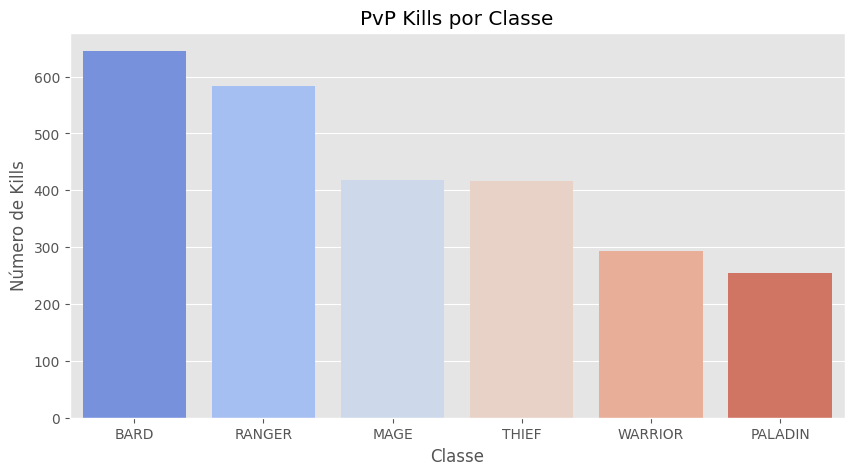

<ipython-input-10-8cc0640e0304>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=boss_counts.index, y=boss_counts.values, palette='viridis')


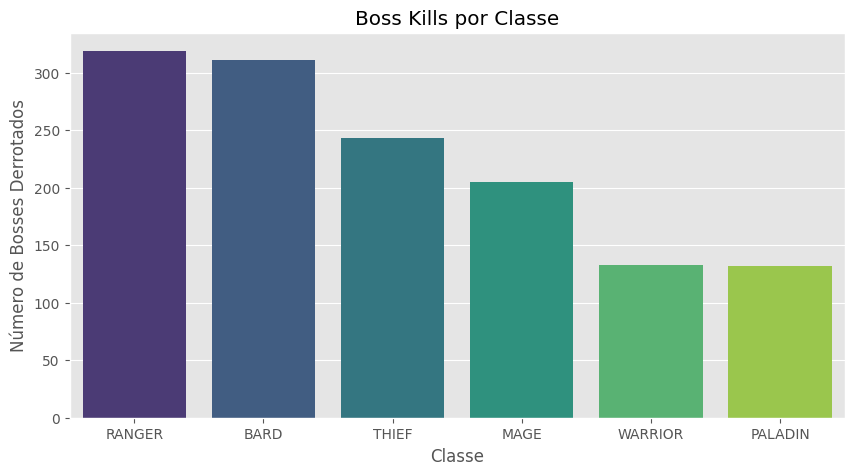

🏆 Melhor Classe no PvP: BARD (645 kills)
🏆 Melhor Classe contra Boss: RANGER (319 kills)


In [10]:
# --- Análise de Performance: PvP e Boss Kills ---

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carregar o arquivo de logs
log_df = pd.read_json('game_logs.jsonl', lines=True)

# Apenas eventos de combate
combate_df = log_df[log_df['combat_data'].notnull()]

# --- PvP Analysis ---
pvp_kills = combate_df[
    (combate_df['event_type'] == 'PVP_KILL') &
    (combate_df['combat_data'].apply(lambda x: x.get('is_killing_blow', False)))
]

pvp_counts = pvp_kills['player_class'].value_counts().sort_values(ascending=False)

# --- Boss Analysis ---
boss_kills = combate_df[
    (combate_df['target_data'].notnull()) &
    (combate_df['target_data'].apply(lambda x: x.get('type') == 'BOSS')) &
    (combate_df['combat_data'].apply(lambda x: x.get('is_killing_blow', False)))
]

boss_counts = boss_kills['player_class'].value_counts().sort_values(ascending=False)

# --- Plotting PvP ---
plt.figure(figsize=(10, 5))
sns.barplot(x=pvp_counts.index, y=pvp_counts.values, palette='coolwarm')
plt.title('PvP Kills por Classe')
plt.xlabel('Classe')
plt.ylabel('Número de Kills')
plt.show()

# --- Plotting Boss ---
plt.figure(figsize=(10, 5))
sns.barplot(x=boss_counts.index, y=boss_counts.values, palette='viridis')
plt.title('Boss Kills por Classe')
plt.xlabel('Classe')
plt.ylabel('Número de Bosses Derrotados')
plt.show()

# --- Melhor Classe ---
melhor_pvp = pvp_counts.idxmax()
melhor_boss = boss_counts.idxmax()

print(f"🏆 Melhor Classe no PvP: {melhor_pvp} ({pvp_counts.max()} kills)")
print(f"🏆 Melhor Classe contra Boss: {melhor_boss} ({boss_counts.max()} kills)")


**Predição — Qual Classe Mata o Boss Mais Rápido**


--- Predição da Classe Mais Rápida em Matar Bosses ---
Analisando 1343 eventos de BOSS_KILL...

Contagem de Boss Kills por Classe:
player_class
RANGER     319
BARD       311
THIEF      243
MAGE       205
WARRIOR    133
PALADIN    132
Name: count, dtype: int64

--- Predição ---
Com base na frequência de 'golpes finais' registrados em bosses:
A classe predita como a 'mais rápida' (mais frequente) em matar bosses é: RANGER (com 319 kills registradas)


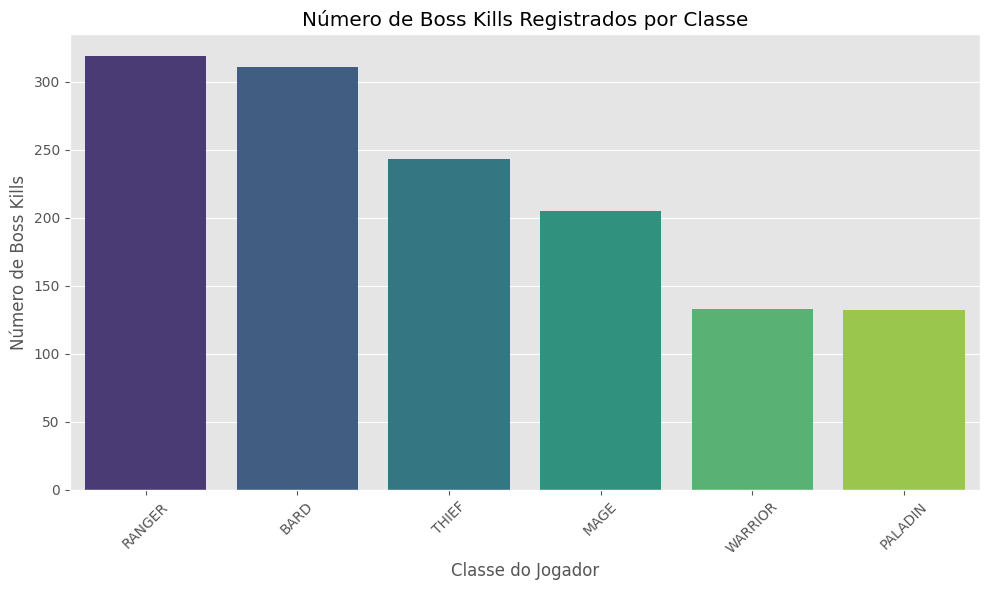


--- Análise Concluída ---


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # Adicione se ainda não estiver importado

# --- Configuração (assumindo que LOG_FILE já está definido) ---
# LOG_FILE = "game_logs.jsonl" # Já definido no notebook

print("\n--- Predição da Classe Mais Rápida em Matar Bosses ---")

# --- Carregar os Dados (assumindo que logs_df já foi carregado e processado) ---
# Verifica se logs_df existe e não está vazio
if 'logs_df' in locals() and not logs_df.empty:
    # --- Filtrar por Eventos BOSS_KILL ---
    # Seleciona apenas as linhas onde o evento é BOSS_KILL
    boss_kills_df = logs_df[logs_df['event_type'] == 'BOSS_KILL'].copy()

    # --- Análise das Classes ---
    if boss_kills_df.empty:
        print("Nenhum evento 'BOSS_KILL' encontrado nos logs.")
        print("Não é possível prever a classe mais rápida.")
    else:
        print(f"Analisando {len(boss_kills_df)} eventos de BOSS_KILL...")

        # Conta a ocorrência de cada classe nos eventos BOSS_KILL
        class_kill_counts = boss_kills_df['player_class'].value_counts()

        if class_kill_counts.empty:
            print("Eventos BOSS_KILL encontrados, mas sem informação de classe associada.")
        else:
            print("\nContagem de Boss Kills por Classe:")
            print(class_kill_counts)

            # Identifica a classe com a maior contagem
            fastest_class = class_kill_counts.idxmax()
            max_kills = class_kill_counts.max()

            print(f"\n--- Predição ---")
            print(f"Com base na frequência de 'golpes finais' registrados em bosses:")
            print(f"A classe predita como a 'mais rápida' (mais frequente) em matar bosses é: {fastest_class} (com {max_kills} kills registradas)")

            # --- Visualização ---
            plt.figure(figsize=(10, 6))
            # Corrige FutureWarning: Atribui x ao hue e desabilita a legenda
            sns.barplot(x=class_kill_counts.index, y=class_kill_counts.values, hue=class_kill_counts.index, palette="viridis", legend=False)
            plt.title('Número de Boss Kills Registrados por Classe')
            plt.xlabel('Classe do Jogador')
            plt.ylabel('Número de Boss Kills')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

else:
    print("DataFrame 'logs_df' não encontrado ou vazio. Execute as células anteriores para carregar e processar os logs.")

print("\n--- Análise Concluída ---")

**Golpe Fatal (Killing Blow)**

In [12]:
# --- Predição: Golpe Fatal (Killing Blow) ---

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Carregar dados
df = pd.read_json('game_logs.jsonl', lines=True)

# Focar apenas em eventos de combate
combat_events = df[df['combat_data'].notnull()]

# Criar features
combat_events['damage'] = combat_events['combat_data'].apply(lambda x: x.get('damage', 0))
combat_events['is_critical'] = combat_events['combat_data'].apply(lambda x: x.get('is_critical', False)).astype(int)
combat_events['is_killing_blow'] = combat_events['combat_data'].apply(lambda x: x.get('is_killing_blow', False)).astype(int)

# Dataset final
X = combat_events[['damage', 'is_critical']]
y = combat_events['is_killing_blow']

# Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo de Classificação
model_killing_blow = RandomForestClassifier()
model_killing_blow.fit(X_train, y_train)

# Avaliação
y_pred = model_killing_blow.predict(X_test)
print(classification_report(y_test, y_pred))

# Exemplo de predição
exemplo = pd.DataFrame({'damage': [600], 'is_critical': [1]})
predicao = model_killing_blow.predict(exemplo)[0]
print("🔮 O golpe será fatal?", "Sim" if predicao == 1 else "Não")


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.98      1.00      0.99       801

    accuracy                           0.98       821
   macro avg       0.49      0.50      0.49       821
weighted avg       0.95      0.98      0.96       821

🔮 O golpe será fatal? Sim


<ipython-input-12-5aff2b036542>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combat_events['damage'] = combat_events['combat_data'].apply(lambda x: x.get('damage', 0))
<ipython-input-12-5aff2b036542>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combat_events['is_critical'] = combat_events['combat_data'].apply(lambda x: x.get('is_critical', False)).astype(int)
<ipython-input-12-5aff2b036542>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l